# Pandas post

## Introduction

El análisis de las carreteras se ha convertido en una tarea indispensable en las ciudades inteligentes. Tener un mayor conocimiento del tráfico permite una mejor organización y gobernanza de las vias. Los datos otorgados por sensonres en ciudades inteligentes suelen ser heterogéneos. En el caso de la ciudad de Madrid en España existen datos climáticos y de tráfico que cubren todo el centro de la ciudad. 

En este artículo utilizaremos estos datos que nos proporciona el ayuntamiento de madrid para hacer un análisis sobre el tráfico y las implicaciones de la meteorología en el tráfico de la ciudad.

## Datasets

Dividiremos esta sección en los datasets de tráfico y los de meteorología.

##  Weather

Los datos de meteorología se capturan de distintas localizaciones . Se nos proporcionan en formato .csv, para descargarlos podemos añadirlos desde [Datos de tiempo](https://datos.madrid.es/portal/site/egob/menuitem.3efdb29b813ad8241e830cc2a8a409a0/?vgnextoid=4950cc720ba29610VgnVCM2000001f4a900aRCRD&vgnextchannel=102612b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default). Se utiliza pandas para cargar los archivos:

In [3]:
import csv 
import pandas as pd

weather = pd.read_csv('dic_meteo22.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

Los datos, tal como se muestra a continuación, tienen una columna magnitud que nos indica que tipo de datos meteorológicos nos muestra la fila:

    · 80: ULTRAVIOLETA
    · 81: VIENTO
    · 82: DIRECCION
    · 83: TEMPERATURA
    · 86: HUMEDAD
    · 87: PRESION
    · 88: SOLAR
    · 89: PRECIPITACION
    
Luego tenemos dos columnas por cada hora de forma que la primera nos indica el valor para el tipo de dato especificado por la columna magnitud y si el resultado es válido o no. Por último, tenemos columnas relacionadas con el tiempo y el lugar donde se hace la medición.

In [4]:
weather.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,108,81,28079108_81_98,2022,12,22,270.0,N,...,218.0,V,228.0,V,227.83,V,213.67,V,233.83,V
1,28,79,108,82,28079108_82_98,2022,12,22,9.0,N,...,10.0,V,10.0,V,9.00,V,9.00,V,8.00,V
2,28,79,108,83,28079108_83_98,2022,12,22,94.7,N,...,86.7,V,91.4,V,93.80,V,96.30,V,98.70,V
3,28,79,108,86,28079108_86_98,2022,12,22,1031.0,N,...,1031.0,V,1031.0,V,1031.00,V,1031.00,V,1031.00,V
4,28,79,108,87,28079108_87_98,2022,12,22,2.0,N,...,1.0,V,3.0,V,2.00,V,3.00,V,3.00,V


Además, para conectar el identificador de la estación meteorológica con las coordenadas tenemos otra tabla:

In [5]:
weather_station = pd.read_csv('Estaciones_control_datos_meteorologicos.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='latin-1')

### Traffic

Los datos de tráfico ...

In [6]:
traffic = pd.read_csv('12-2022.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()

prueba

In [12]:
traffic.head()

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2022-12-01 00:00:00,M30,3240,9.0,0,59.0,N,5
1,1001,2022-12-01 00:15:00,M30,3240,9.0,0,59.0,N,5
2,1001,2022-12-01 00:30:00,M30,300,1.0,0,66.0,N,5
3,1001,2022-12-01 00:45:00,M30,300,1.0,0,66.0,N,5
4,1001,2022-12-01 01:00:00,M30,300,1.0,0,66.0,N,5


In [7]:
traffic_station = pd.read_csv('pmed_ubicacion_12-2022.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

## Cleaning Dataset

Los datos anteriores no tienen un formato adecuado para trabajar con ellos.

### Weather

En el dataset del clima tenemos la fecha separada en día, mes y año, pero en tráfico están todos estos datos juntos. Es por esto que se agruparán las columnas.

In [8]:
weather = weather.rename(columns={"ANO": "year", "MES": "month", "DIA":"day", "MAGNITUD":"magnitud", "ESTACION":"weather_station"})
weather["date"] = pd.to_datetime(weather[["year", "month", "day"]])

El siguiente paso será el transformar en filas independientes las columnas del valor y su validez por hora:

In [9]:
import re
weather_hour = weather.melt(id_vars=["weather_station", "magnitud", "date"],
                            value_vars=[x for x in weather.columns if re.match("^H", x)],
                            var_name="hour")

weather_valid = weather.melt( value_vars=[x for x in weather.columns if re.match("^V", x)], var_name="valid")

Ahora se pueden eliminar las mediciones no válidas:

In [10]:
weather= weather_hour[weather_valid["value"] == "V"].reset_index()

Ahora para asemejarlo a la tabla de tráfico se puede añadir la hora junto a la fecha:

In [11]:
weather["hour"] = weather["hour"].str[1:]
weather["hour"] = pd.to_timedelta(weather['hour'].astype(int)-1, unit='h')
weather["date"] = weather["date"] + weather["hour"]

Ahora podemos separar las distintas métricas:

In [12]:
weather_values = weather.assign(MAGNITUD = weather["magnitud"].map({80:"ultraviolet",
                                                             81:"wind",
                                                             82:"direction",
                                                             83:"temperature",
                                                             86:"humidity",
                                                             87:"pressure",
                                                             88:"solar",
                                                             89:"rainfall"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") 

In [13]:
# Unirlo a la anterior tabla
weather = pd.concat([weather, weather_values], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.drop(["index", "hour", "magnitud", "value"], axis=1).groupby([ "date", "weather_station"]).sum().reset_index()

## Traffic

La tabla de tráfico...

In [14]:
# Quitar datos con errores
traffic= traffic[traffic["error"] == "N"]

In [15]:
# String a fecha
traffic['date'] = pd.to_datetime(traffic['fecha'], errors='coerce')

In [16]:
# Eliminar columnas innecesarias
traffic.drop(["tipo_elem", "error", "periodo_integracion", "fecha", "intensidad", "ocupacion", "vmed"], axis=1, inplace=True)

In [17]:
traffic = traffic.groupby([pd.Grouper(key="date", freq='1H'), 'id']).mean().rename(columns={"carga":"load"})

### Location

Para juntar las dos anteriores tablas necesitamos saber que sensores de tráfico se corresponden con las estaciones meteorológicas. Para ello se puede utilizar una matriz de distancias y encontrar los pares más cercanos.

In [21]:
# Calculo de distancias de sensores meteo y trafico
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist
import numpy as np

weather_station = weather_station.rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
traffic_station = traffic_station.rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})

unit = Unit.KILOMETERS 
distance_matrix = haversine_vector(weather_station[["Latitude", "Longitude"]], traffic_station[["Latitude", "Longitude"]], unit, comb=True)

distance_table = pd.DataFrame.from_dict({'Distance': distance_matrix.argmin(axis=1), 'Closest':np.array(distance_matrix.min(axis=1), dtype=int)})
distance_table = distance_table.join(weather_station[["CÓDIGO_CORTO"]], on="Closest").rename(columns={"CÓDIGO_CORTO": 'weather_station'})
distance_table["id"] = distance_table.index

## Join datasets

In [22]:
# Juntar tiempo con distancias
complete = weather.merge(distance_table, on="weather_station")
# Juntar anterior con trafico
complete = complete.merge(traffic, on=["id", "date"])
# Renombra columna id por estacion_traf
complete.rename(columns={"id": 'traffic_station'}, inplace=True)
# Añadir dia de la semana y hora
complete["WEEKDAY"] = complete["date"].dt.weekday
complete["HOUR"] = complete["date"].dt.hour

In [253]:
complete

,date,weather_station,direction,humidity,pressure,rainfall,solar,temperature,wind,Distance,Closest,station,traffic_station,load,WEEKDAY,HOUR
0,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,4,1009,0.00,3,0
1,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,4,1010,0.00,3,0
2,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,4,1011,0.00,3,0
3,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,4,1012,0.00,3,0
4,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,4,1013,0.00,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841063,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,35,3858,2.75,5,23
841064,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,35,4609,7.50,5,23
841065,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,35,4610,3.25,5,23
841066,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,35,4663,2.50,5,23


## Data interpretation

In [248]:
complete[["humidity", "direction", "pressure", "rainfall", "solar", "temperature", "wind"]].describe()

,humidity,direction,pressure,rainfall,solar,temperature,wind
count,827660.000000,827660.000000,827660.000000,827660.000000,827660.000000,827660.000000,827660.000000
mean,55.400488,13.096740,82.473610,0.013241,4.817006,9.853277,0.102880
std,42.428486,51.389659,267.076674,0.195510,33.478701,2.917635,0.426513
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,8.200000,0.000000
50%,78.000000,0.000000,0.000000,0.000000,0.000000,9.900000,0.000000
75%,93.000000,0.000000,0.000000,0.000000,0.000000,11.600000,0.000000
max,100.000000,358.000000,964.000000,10.900000,469.000000,20.700000,4.800000


Los días lectivos suelen tener más tráfico que los días festivos. Así como de día suele haber más tráfico que de noche. En la siguiente figura podemos comprobarlo. De lunes a viernes hay más tráfico y de 11 a 20 también. Vemos entonces que existe una fuerte estacionalidad en los datos.

In [254]:
complete.groupby("HOUR")["load"].mean()

HOUR
0     11.529925
1      8.814131
2      6.584377
3      5.204392
4      4.528750
5      4.747956
6      7.435646
7     13.684069
8     20.288830
9     22.915114
10    23.285033
11    25.824864
12    27.946681
13    29.289292
14    30.119622
15    25.844869
16    23.806645
17    26.245837
18    27.792364
19    28.545421
20    27.505312
21    22.935354
22    16.859255
23    12.930452
Name: load, dtype: float64

In [255]:
complete.groupby("WEEKDAY")["load"].mean()

WEEKDAY
0    19.009195
1    19.196841
2    21.170531
3    20.503766
4    22.108984
5    16.511120
6    14.340566
Name: load, dtype: float64

Estudiemos la dependencia de las precepitaciones y la temperatura sobre la carga. En primer lugar debemos saber como se distribuyen ambas:

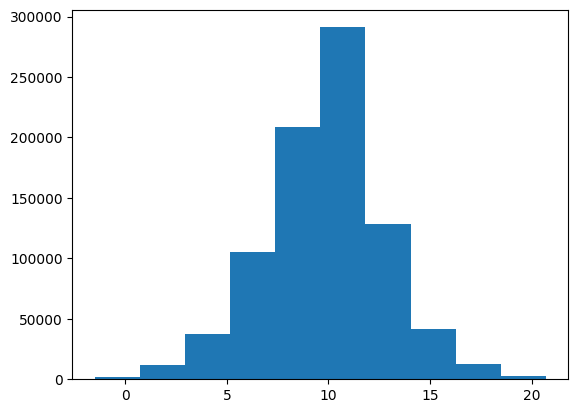

In [256]:
import matplotlib.pyplot as plt
hist = plt.hist(complete["temperature"])
plt.show()

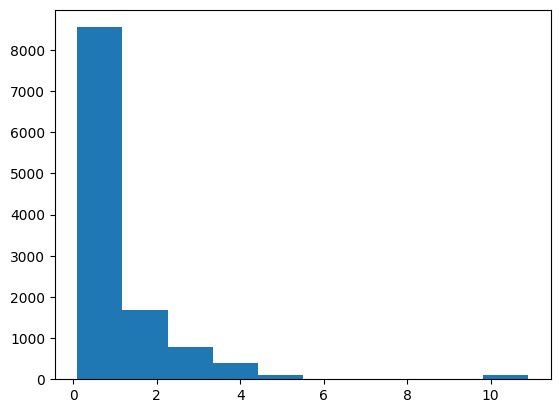

In [258]:
hist = plt.hist(complete[complete["rainfall"]>0]["rainfall"])
plt.show()

In [24]:
# Entrada
final = complete[(complete["WEEKDAY"]<5) & (complete["load"]>1)]
#final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])
final["rainfall_m"] = pd.cut(final["rainfall"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])
final["temperature_m"] = pd.cut(final["temperature"], [-10,5, 10,15, np.inf], labels=["Freeze", "Cold", "Hot","Warm"])
#final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 60, 70, 80, 90,np.inf], labels=["None","None_Light","Light", "Light-moderate", "Moderate", "Moderate-heavy", "Heavy", "Heavy-Stop", "Stop"])
final["carga_m"] = pd.cut(final["load"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])

<ipython-input-24-4152996f3e0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["rainfall_m"] = pd.cut(final["rainfall"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])
<ipython-input-24-4152996f3e0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["temperature_m"] = pd.cut(final["temperature"], [-10,5, 10,15, np.inf], labels=["Freeze", "Cold", "Hot","Warm"])
<ipython-input-24-4152996f3e0e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


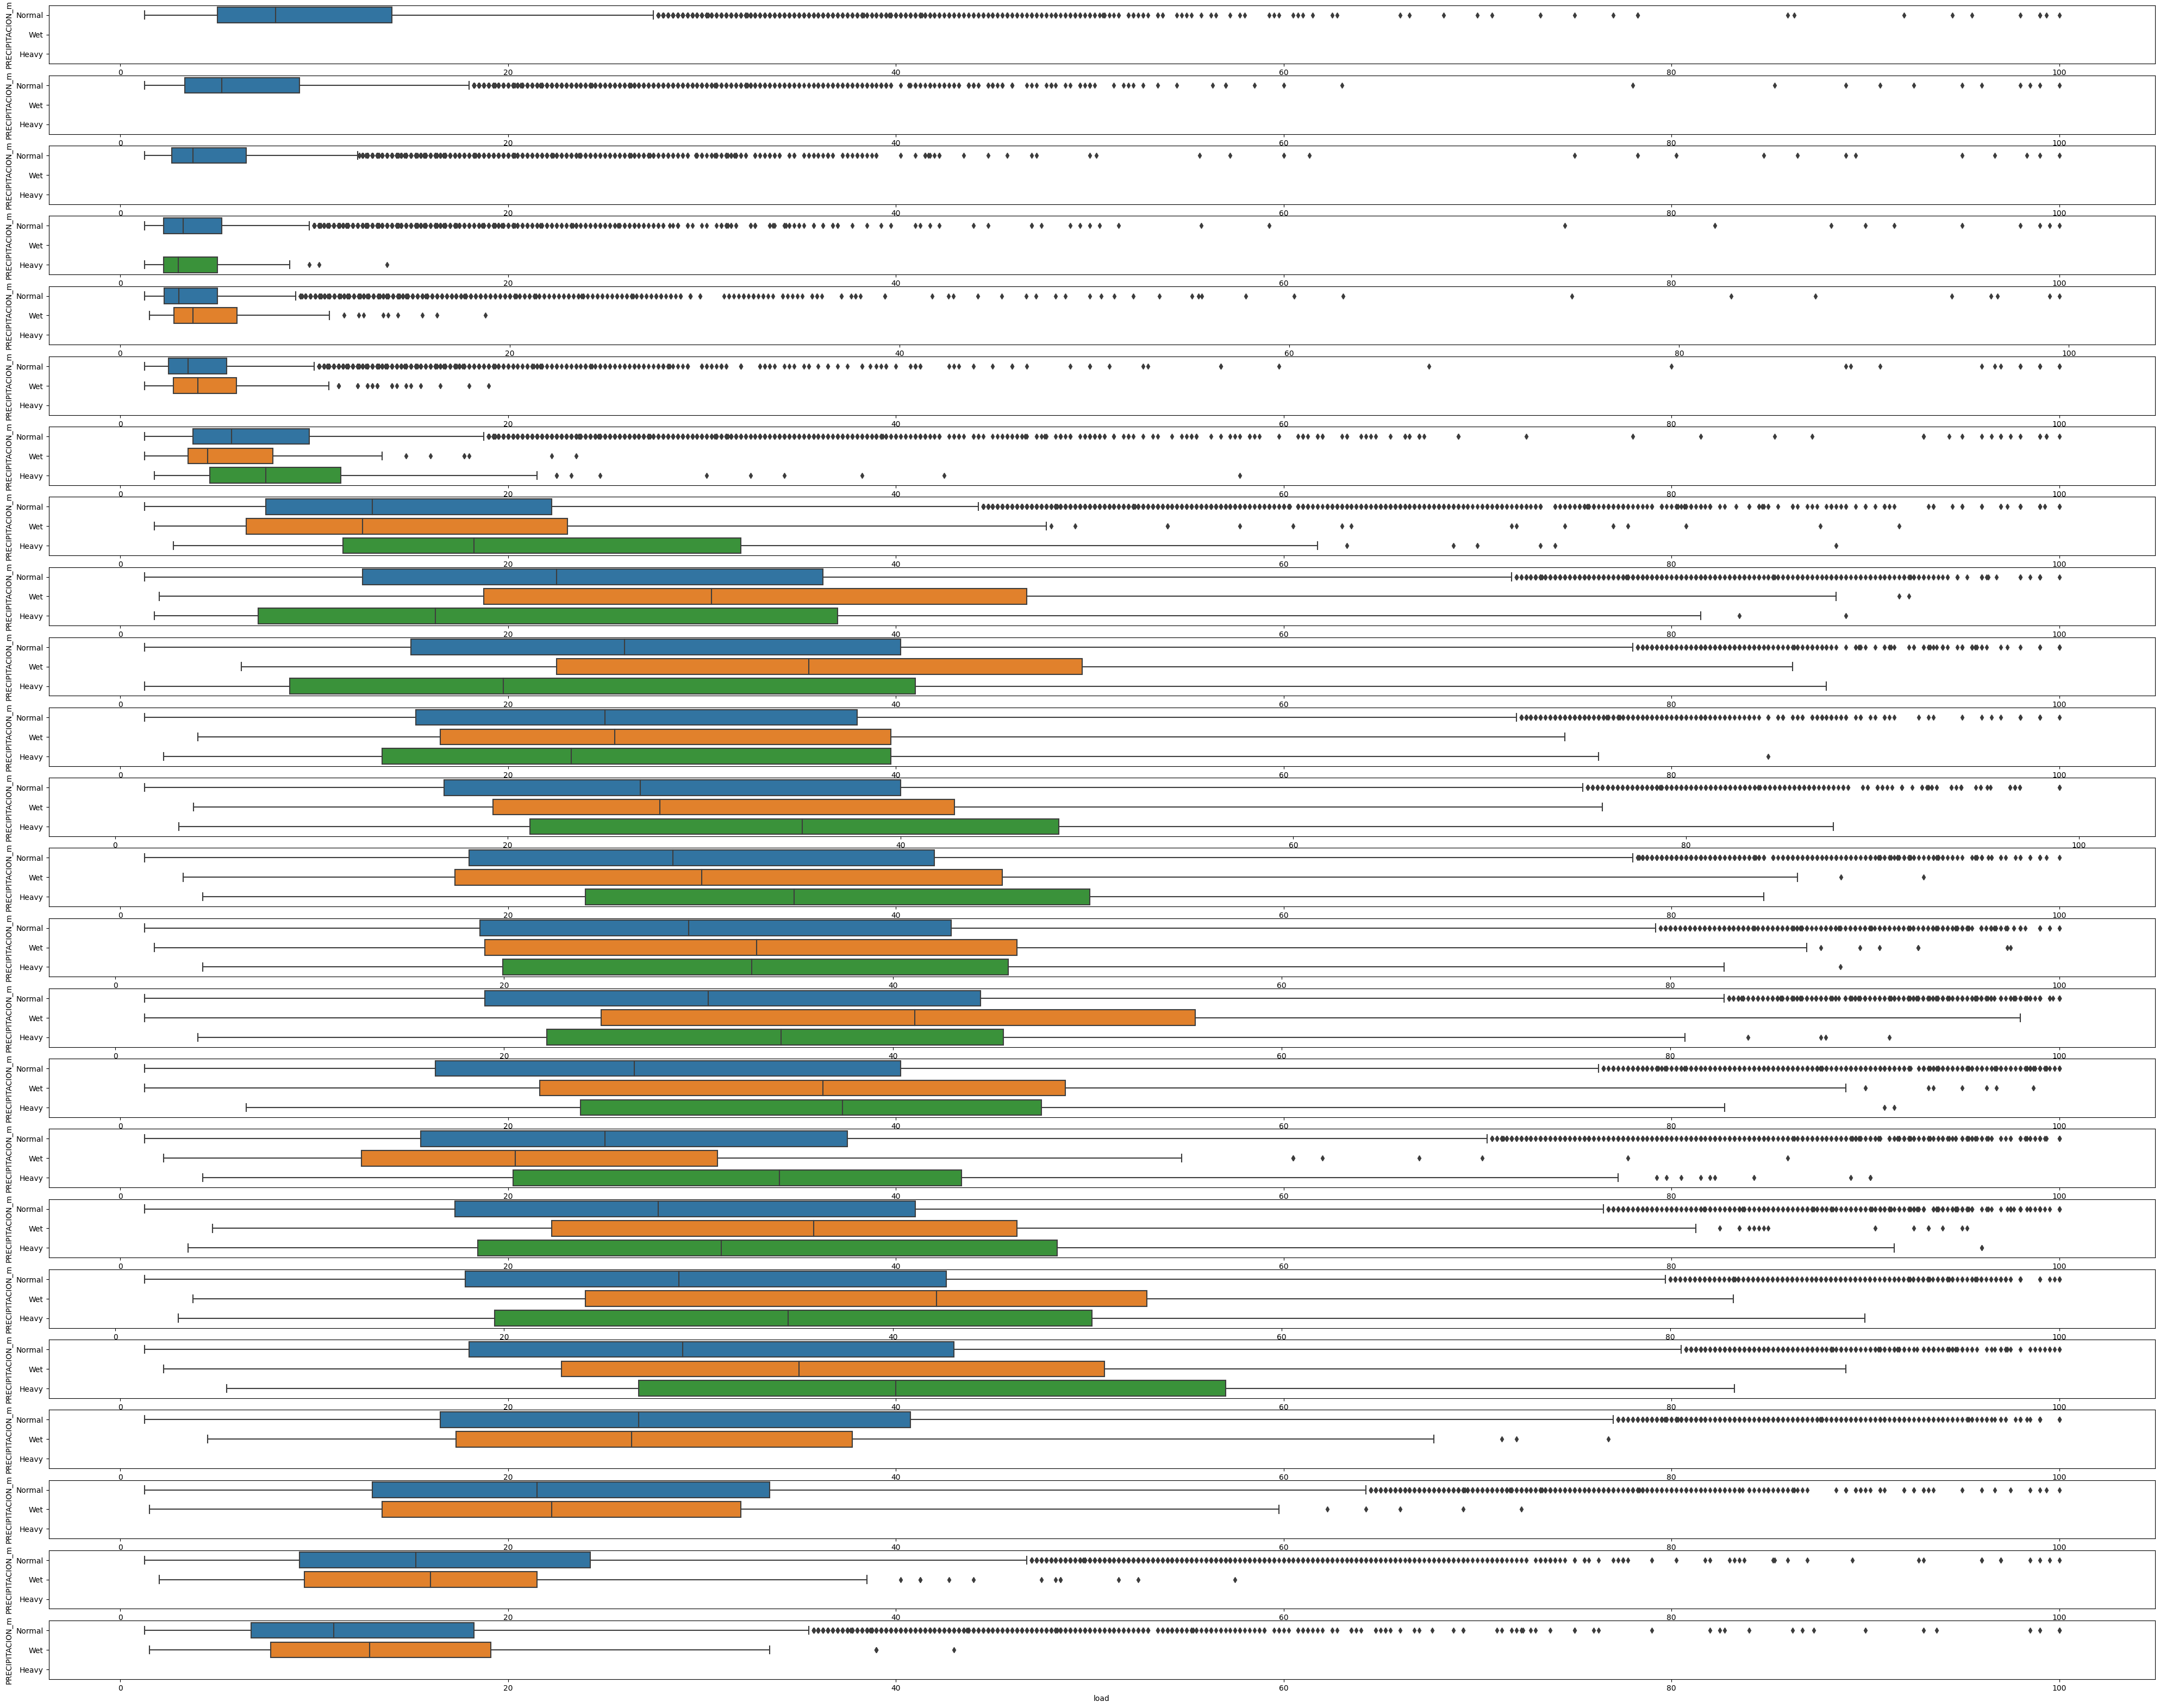

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(24, figsize=(50, 40))
for i in range(24):
    sns.boxplot(x="load", y="PRECIPITACION_m", data=final[final["HOUR"]==i], ax=ax[i])
#sns.swarmplot(x="carga_v", y="TEMPERATURA", data=final,  ax=ax)
plt.show()

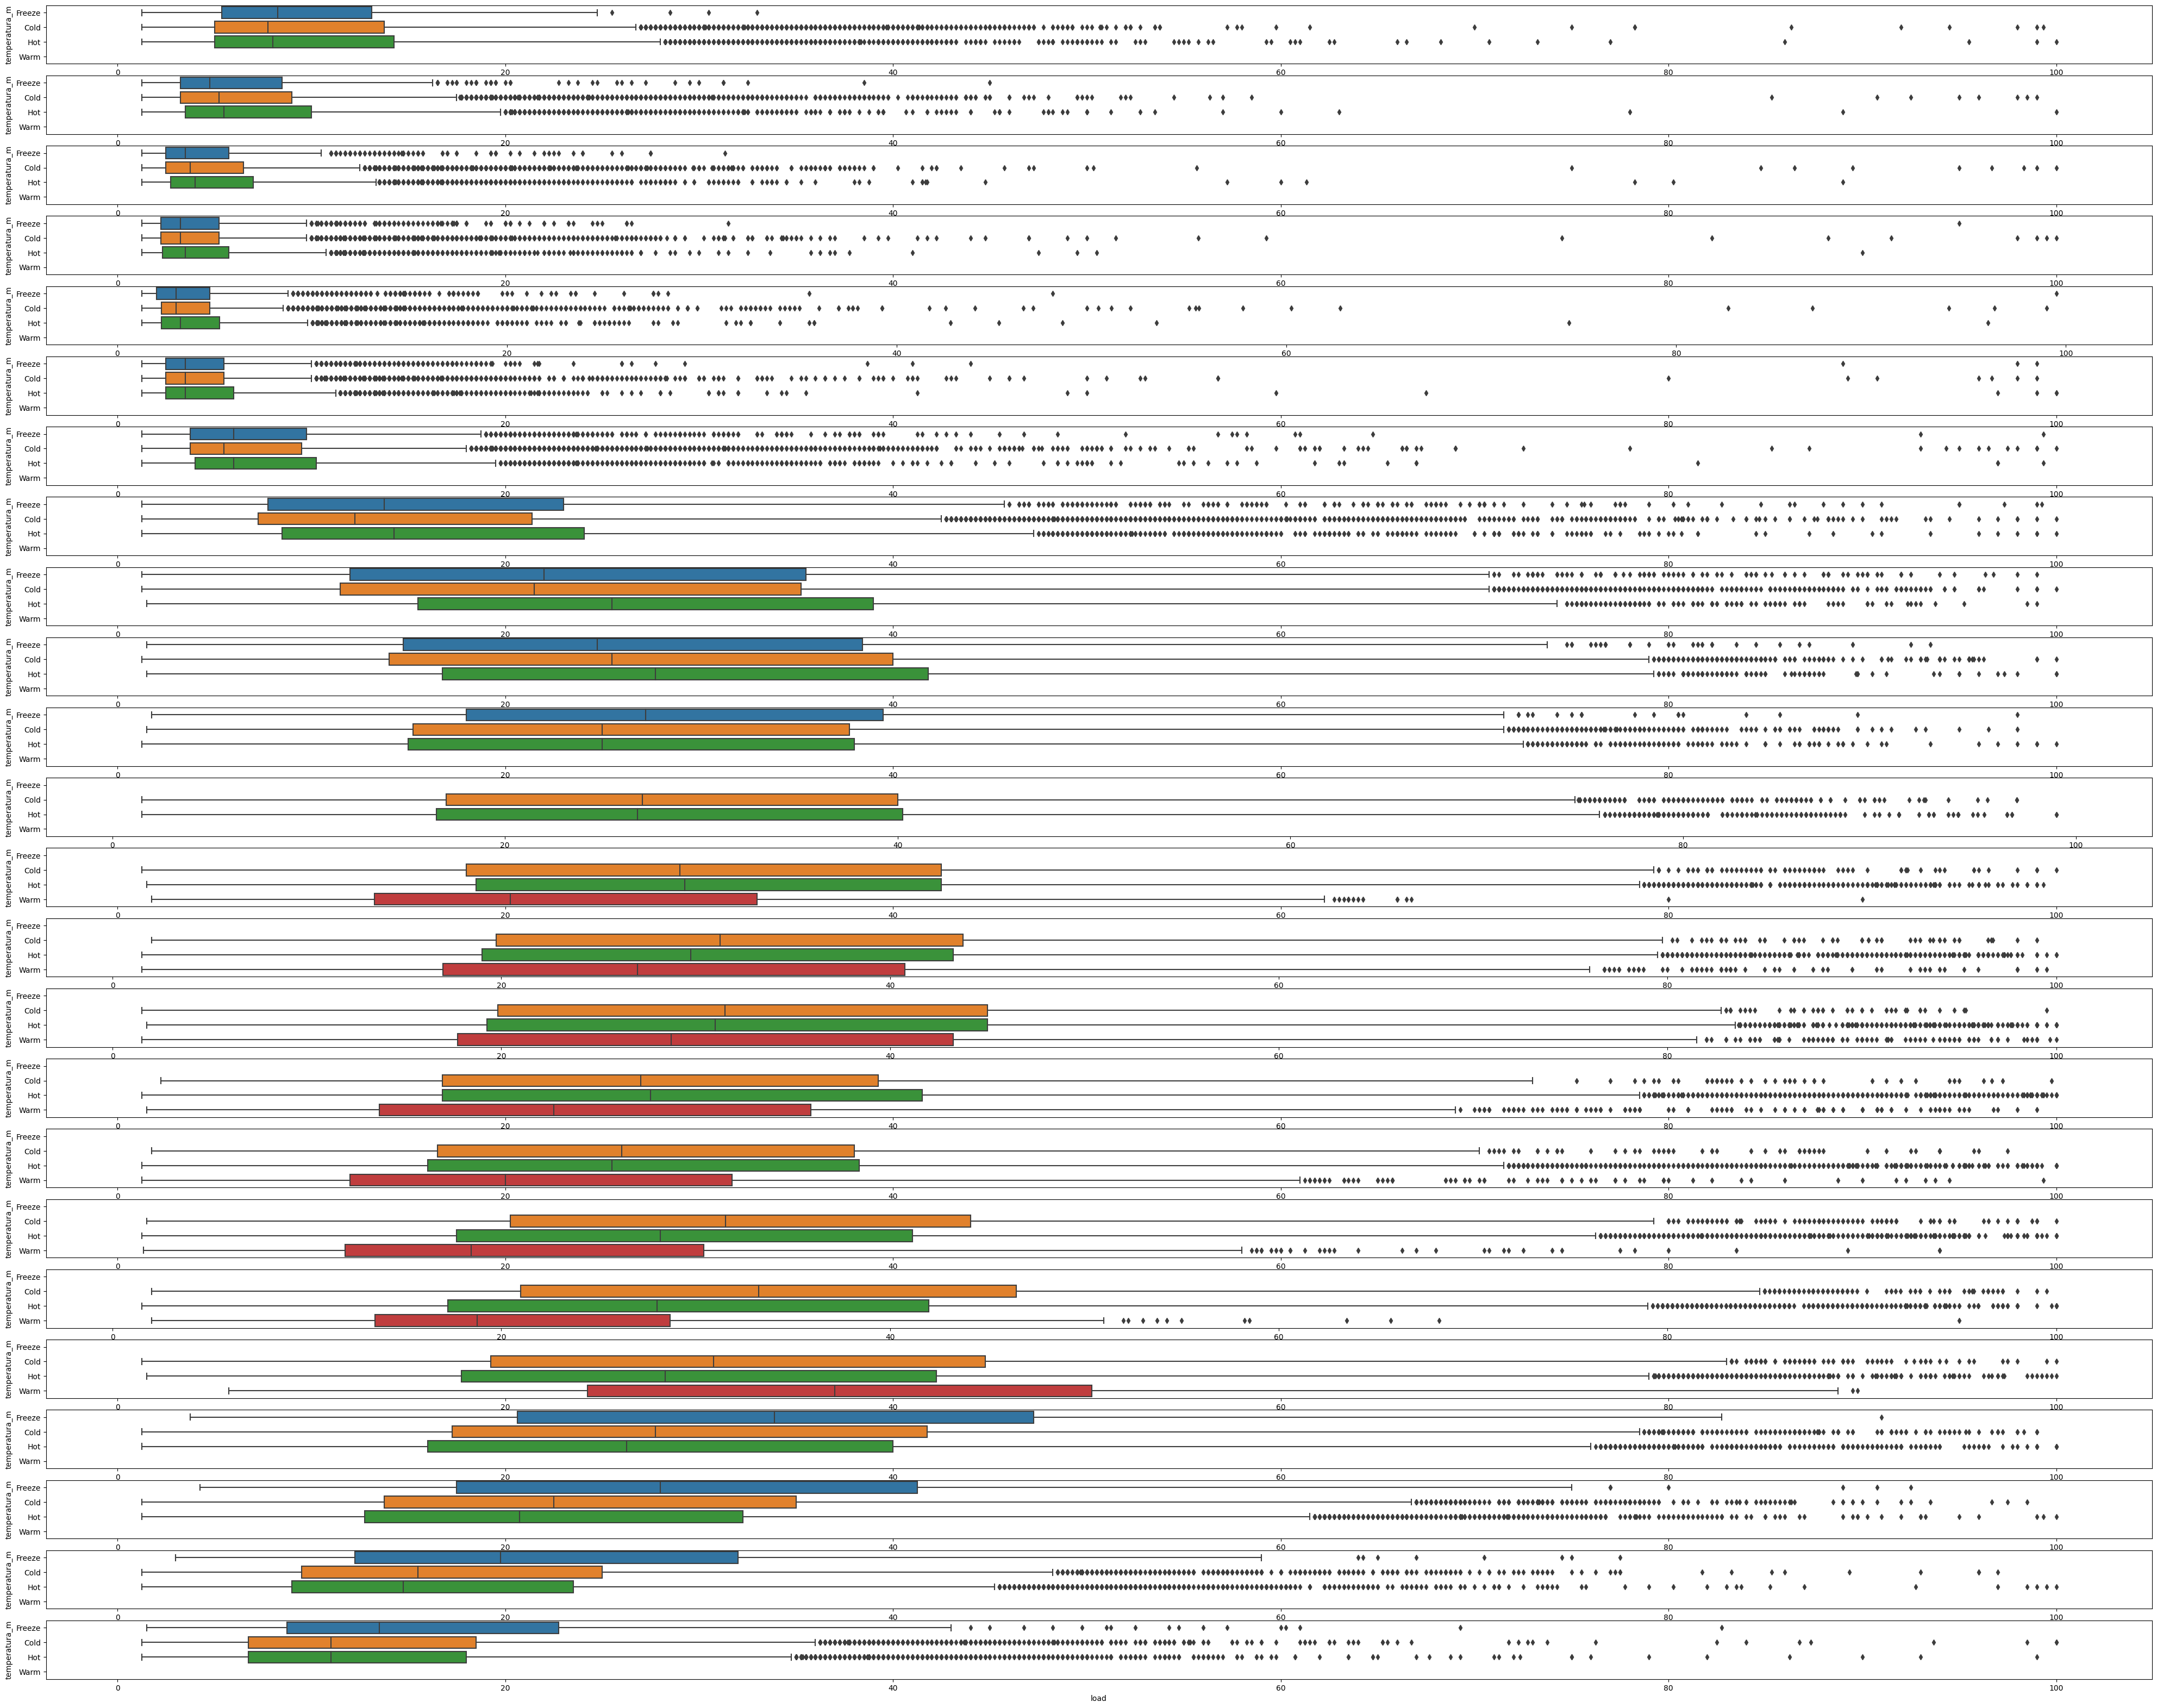

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(24, figsize=(50, 40))
for i in range(24):
    sns.boxplot(x="load", y="temperatura_m", data=final[final["HOUR"]==i], ax=ax[i])
#sns.swarmplot(x="carga_v", y="TEMPERATURA", data=final,  ax=ax)
plt.show()

HORA  0
                   sum_sq       df         F    PR(>F)
C(rainfall)  1.656473e+02      1.0  2.261131  0.132671
Residual     1.700113e+06  23207.0       NaN       NaN
ERROR HORA  1
ERROR HORA  2
HORA  3
                    sum_sq       df         F    PR(>F)
C(rainfall)     151.847129      2.0  3.692845  0.024918
Residual     419889.543967  20423.0       NaN       NaN
HORA  4
                    sum_sq       df         F    PR(>F)
C(rainfall)      98.518654      2.0  2.693969  0.067637
Residual     361294.102439  19759.0       NaN       NaN
HORA  5
                    sum_sq       df         F    PR(>F)
C(rainfall)      95.525008      3.0  1.428687  0.232218
Residual     467499.935567  20976.0       NaN       NaN
HORA  6
                   sum_sq       df         F    PR(>F)
C(rainfall)  7.075834e+02      2.0  6.214456  0.002004
Residual     1.320388e+06  23193.0       NaN       NaN
HORA  7
                   sum_sq       df          F        PR(>F)
C(rainfall)  2.065590e+04     

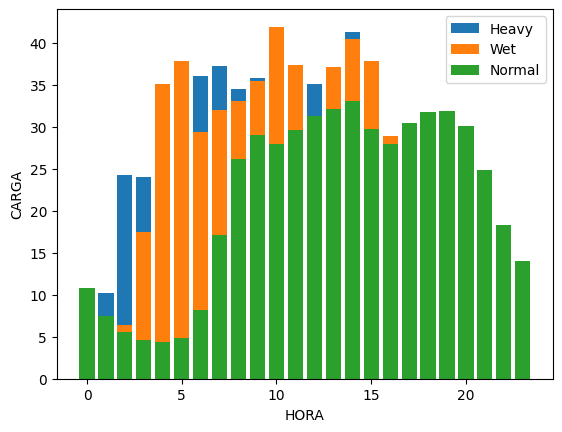

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt


lista = []
j = ["Heavy", "Wet", "Normal"]
for i in j:
    t = final[final["rainfall_m"]== i]
    lista.append(t[["load","HOUR",  "rainfall_m"]].groupby(["HOUR", "rainfall_m"]).agg({'load': 'mean'}).dropna().values)

for i in range(24):
    try:
        model = ols('load ~ C(rainfall)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('load ~ C(rainfall)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
    
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("CARGA")
plt.xlabel("HORA")
plt.show()

HORA  0
                      sum_sq       df          F         PR(>F)
C(temperature)  5.830928e+04     63.0  13.046357  5.763203e-130
Residual        1.641969e+06  23145.0        NaN            NaN
HORA  1
                       sum_sq       df          F         PR(>F)
C(temperature)   43941.841616     72.0  14.127161  1.033893e-162
Residual        984414.500361  22787.0        NaN            NaN
HORA  2
                       sum_sq       df          F         PR(>F)
C(temperature)   23675.203620     68.0  12.967137  1.336210e-138
Residual        582344.855024  21689.0        NaN            NaN
HORA  3
                       sum_sq       df         F        PR(>F)
C(temperature)   10916.814265     68.0  7.988132  4.750197e-74
Residual        409124.576831  20357.0       NaN           NaN
HORA  4
                       sum_sq       df         F        PR(>F)
C(temperature)    7579.555060     69.0  6.113791  2.045204e-51
Residual        353813.066034  19692.0       NaN           NaN


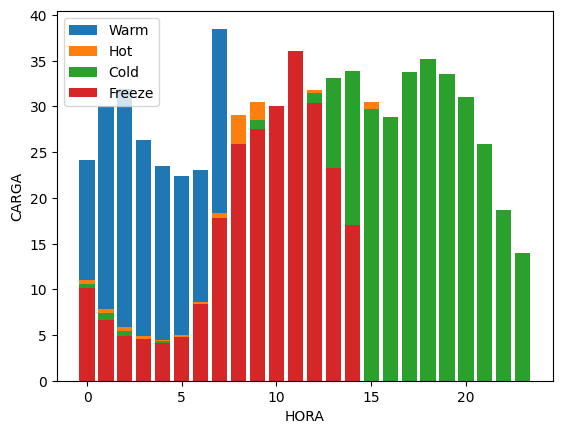

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lista = []
j = ["Freeze", "Cold", "Hot","Warm"][::-1]
for i in j:
    t = final[final["temperature_m"]== i]
    lista.append(t[["load","HOUR",  "temperature_m"]].groupby(["HOUR", "temperature_m"]).agg({'load': 'mean'}).dropna().values)

for i in range(24):
    try:
        model = ols('load ~ C(temperature)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('load ~ C(temperature)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
    
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("CARGA")
plt.xlabel("HORA")
plt.show()

## Modelo

# Cosas

In [283]:
lista

[array([[10.18150087],
        [ 6.61469298],
        [ 4.84124424],
        [ 4.593855  ],
        [ 4.18061281],
        [ 4.7403787 ],
        [ 8.37158681],
        [17.84467474],
        [25.94517897],
        [27.5315097 ],
        [30.01408324],
        [36.03826531],
        [30.34688581],
        [23.30853518],
        [16.98646209]]),
 array([[10.61446377],
        [ 7.37880319],
        [ 5.49245347],
        [ 4.58931133],
        [ 4.30648103],
        [ 4.77645053],
        [ 8.02494128],
        [16.44233434],
        [25.23808546],
        [28.53399428],
        [27.74955843],
        [29.77280313],
        [31.49260584],
        [33.11247642],
        [33.88473937],
        [29.7320925 ],
        [28.87651353],
        [33.75189914],
        [35.1680336 ],
        [33.50429894],
        [30.98943318],
        [25.91899602],
        [18.72514024],
        [14.00019801]]),
 array([[11.06279765],
        [ 7.87821043],
        [ 5.8433458 ],
        [ 4.876803  ],
       

In [263]:
final

,date,weather_station,direction,humidity,pressure,rainfall,solar,temperature,wind,Distance,Closest,station,traffic_station,load,WEEKDAY,HOUR,PRECIPITACION_m,temperatura_m,carga_m
24,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,3,0,4,3722,9.25,3,0,Normal,Cold,<10
25,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,3,0,4,3723,2.25,3,0,Normal,Cold,<10
26,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3744,9.25,3,0,Normal,Cold,<10
27,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3745,29.00,3,0,Normal,Cold,20
28,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3746,5.25,3,0,Normal,Cold,<10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840528,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,3858,12.25,4,23,Normal,Cold,10
840529,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4609,12.00,4,23,Normal,Cold,10
840530,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4610,7.50,4,23,Normal,Cold,<10
840531,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4663,11.25,4,23,Normal,Cold,10


In [ ]:
# Entrada
final = df5[(df5["WEEKDAY"]<5) & (df5["carga"]>1)]
#final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])
final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])

#final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 60, 70, 80, 90,np.inf], labels=["None","None_Light","Light", "Light-moderate", "Moderate", "Moderate-heavy", "Heavy", "Heavy-Stop", "Stop"])
final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])


In [ ]:
weather= weather_ori.melt(id_vars=["ESTACION", "MAGNITUD", "FECHA"],
                          value_vars=[x for x in weather_ori.columns if re.match("^H", x)],
                          var_name="HORA")

weather2 = weather_ori.melt( value_vars=[x for x in weather_ori.columns if re.match("^V", x)])


weather["HORA"] = weather["HORA"].str[1:]
weather["HORA"] = pd.to_timedelta(weather['HORA'].astype(int)-1, unit='h')
weather["FECHA"] = weather["FECHA"] + weather["HORA"]


weather= weather[weather2["value"] == "V"]


df1 = weather.assign(MAGNITUD = weather["MAGNITUD"].map({80:"ULTRAVIOLETA",
                                                             81:"VIENTO",
                                                             82:"DIRECCION",
                                                             83:"TEMPERATURA",
                                                             86:"HUMEDAD",
                                                             87:"PRESION",
                                                             88:"SOLAR",
                                                             89:"PRECIPITACION"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") \

# Unirlo a la anterior tabla
weather = pd.concat([weather, df1], axis=1).drop(['MAGNITUD', "value", "HORA"], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.groupby([ "FECHA", "ESTACION"]).sum().reset_index()

In [60]:
import re
import pandas as pd
import numpy as np
import csv 

import pandas as pd
import csv
import numpy as np
from scipy.spatial.distance import cdist
import re
import pandas as pd
import numpy as np
import csv

#################################################################################################################################
##########################################  CARGA DE DATOS ######################################################################
#################################################################################################################################

#Cargar tabla trafico
trafico = pd.read_csv('12-2022.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()

#Cargar tabla meteorológica
weather_ori = pd.read_csv('dic_meteo22.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

#Carga tablas estaciones y localizaciones
df3 = pd.read_csv('pmed_ubicacion_12-2022.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()
df4 = pd.read_csv('Estaciones_control_datos_meteorologicos.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='latin-1')

# Cambiar Año/Mes/Dia por fecha
weather_ori = weather_ori.rename(columns={"ANO": "year", "MES": "month", "DIA":"day"})
weather_ori["FECHA"] = pd.to_datetime(weather_ori[["year", "month", "day"]])


# Quitar datos con errores
trafico= trafico[trafico["error"] == "N"]
# String a fecha
trafico['FECHA'] = pd.to_datetime(trafico['fecha'], errors='coerce')
# Eliminar columnas innecesarias
trafico.drop(["tipo_elem", "error", "periodo_integracion", "fecha"], axis=1, inplace=True)
# Agrupar los datos de hora en hora
trafico.resample("1H", on="FECHA").mean()

####################################################################################################################################
###############################  PREPROCESADO METEO ################################################################################
####################################################################################################################################

# Separacion por horas de las H
weather= weather_ori.melt(id_vars=["ESTACION", "MAGNITUD", "FECHA"],
                          value_vars=[x for x in weather_ori.columns if re.match("^H", x)],
                          var_name="HORA")
# Separacion por horas de las V
weather2 = weather_ori.melt( value_vars=[x for x in weather_ori.columns if re.match("^V", x)])

# Entero a Hora
weather["HORA"] = weather["HORA"].str[1:]
weather["HORA"] = pd.to_timedelta(weather['HORA'].astype(int)-1, unit='h')
weather["FECHA"] = weather["FECHA"] + weather["HORA"]

# Seleccion de los valores == V
weather= weather[weather2["value"] == "V"]

# Mapeado de los datos de magnitud con los valores
df1 = weather.assign(MAGNITUD = weather["MAGNITUD"].map({80:"ULTRAVIOLETA",
                                                             81:"VIENTO",
                                                             82:"DIRECCION",
                                                             83:"TEMPERATURA",
                                                             86:"HUMEDAD",
                                                             87:"PRESION",
                                                             88:"SOLAR",
                                                             89:"PRECIPITACION"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") \

# Unirlo a la anterior tabla
weather = pd.concat([weather, df1], axis=1).drop(['MAGNITUD', "value", "HORA"], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.groupby([ "FECHA", "ESTACION"]).sum().reset_index()

In [153]:
####################################################################################################################################
###############################  PREPROCESADO DISTANCIAS ###########################################################################
####################################################################################################################################

# Calculo de distancias de sensores meteo y trafico
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist
a1 = df4[[ "LATITUD", "LONGITUD"]].rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
a2 = df3[["\"latitud\"", "\"longitud\""]].rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})
#cdist(a1, a2, method= haversine_vector)
unit = Unit.KILOMETERS 
dm = haversine_vector(a1, a2, unit, comb=True)

#distancias["id"] = pd.Series([df3.index[np.argmin(x)] for x in cdist(df4[["LONGITUD", "LATITUD"]], df3[["\"longitud\"","\"latitud\""]])])
distancias = pd.DataFrame.from_dict({'Distance': dm.argmin(axis=1), 'Closest':np.array(dm.min(axis=1), dtype=int)})
distancias = distancias.join(df4[["CÓDIGO_CORTO"]], on="Closest")
distancias = distancias.rename(columns={"CÓDIGO_CORTO": 'ESTACION'})
distancias["id"] = distancias.index


####################################################################################################################################
############################### JUNTAR TABLAS ######################################################################################
####################################################################################################################################

# Juntar tiempo con distancias
df5 = weather.merge(distancias, on="ESTACION")
# Juntar anterior con trafico
df5 = df5.merge(trafico, on=["id", "FECHA"])
# Renombra columna id por estacion_traf
df5.rename(columns={"id": 'estacion_traf'}, inplace=True)
# Añadir dia de la semana y hora
df5["WEEKDAY"] = df5["FECHA"].dt.weekday
df5["HOUR"] = df5["FECHA"].dt.hour

####################################################################################################################################
############################### MODELO SKLEARN #####################################################################################
####################################################################################################################################

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# Entrada
final = df5[(df5["WEEKDAY"]<5) & (df5["carga"]>1)]
#final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])
final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])

#final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 60, 70, 80, 90,np.inf], labels=["None","None_Light","Light", "Light-moderate", "Moderate", "Moderate-heavy", "Heavy", "Heavy-Stop", "Stop"])
final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])

X = final[["HOUR", "WEEKDAY", "DIRECCION",  "HUMEDAD",  "PRECIPITACION",  "PRESION",  "SOLAR",  "TEMPERATURA",  "VIENTO" ]].to_numpy()
# Preprocesado de la entrada
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# Salida
y = final[["carga_m"]].to_numpy().ravel()

# Definicion y entrenamiento del modelo
reg = LogisticRegression(max_iter=10000).fit(X, y)

#Resultado
print(reg.score(X, y))

<ipython-input-153-2901032e1011>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])
<ipython-input-153-2901032e1011>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])


0.38622995046585684


In [48]:
l = final[final["vmed"] > 0]

In [30]:
trafico = pd.read_csv('05-2023.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()
trafico

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2023-05-01 00:00:00,C30,1152,2.0,0,59.0,N,5
1,1001,2023-05-01 00:15:00,C30,780,2.0,0,60.0,N,5
2,1001,2023-05-01 00:30:00,C30,732,2.0,0,63.0,N,5
3,1001,2023-05-01 00:45:00,C30,828,2.0,0,62.0,N,5
4,1001,2023-05-01 01:00:00,C30,612,2.0,0,60.0,N,5
...,...,...,...,...,...,...,...,...,...
12926310,11122,2023-05-31 22:45:00,URB,93,0.0,7,0.0,N,9
12926311,11122,2023-05-31 23:00:00,URB,92,0.0,8,0.0,N,13
12926312,11122,2023-05-31 23:15:00,URB,56,0.0,6,0.0,N,15
12926313,11122,2023-05-31 23:30:00,URB,60,0.0,5,0.0,N,15


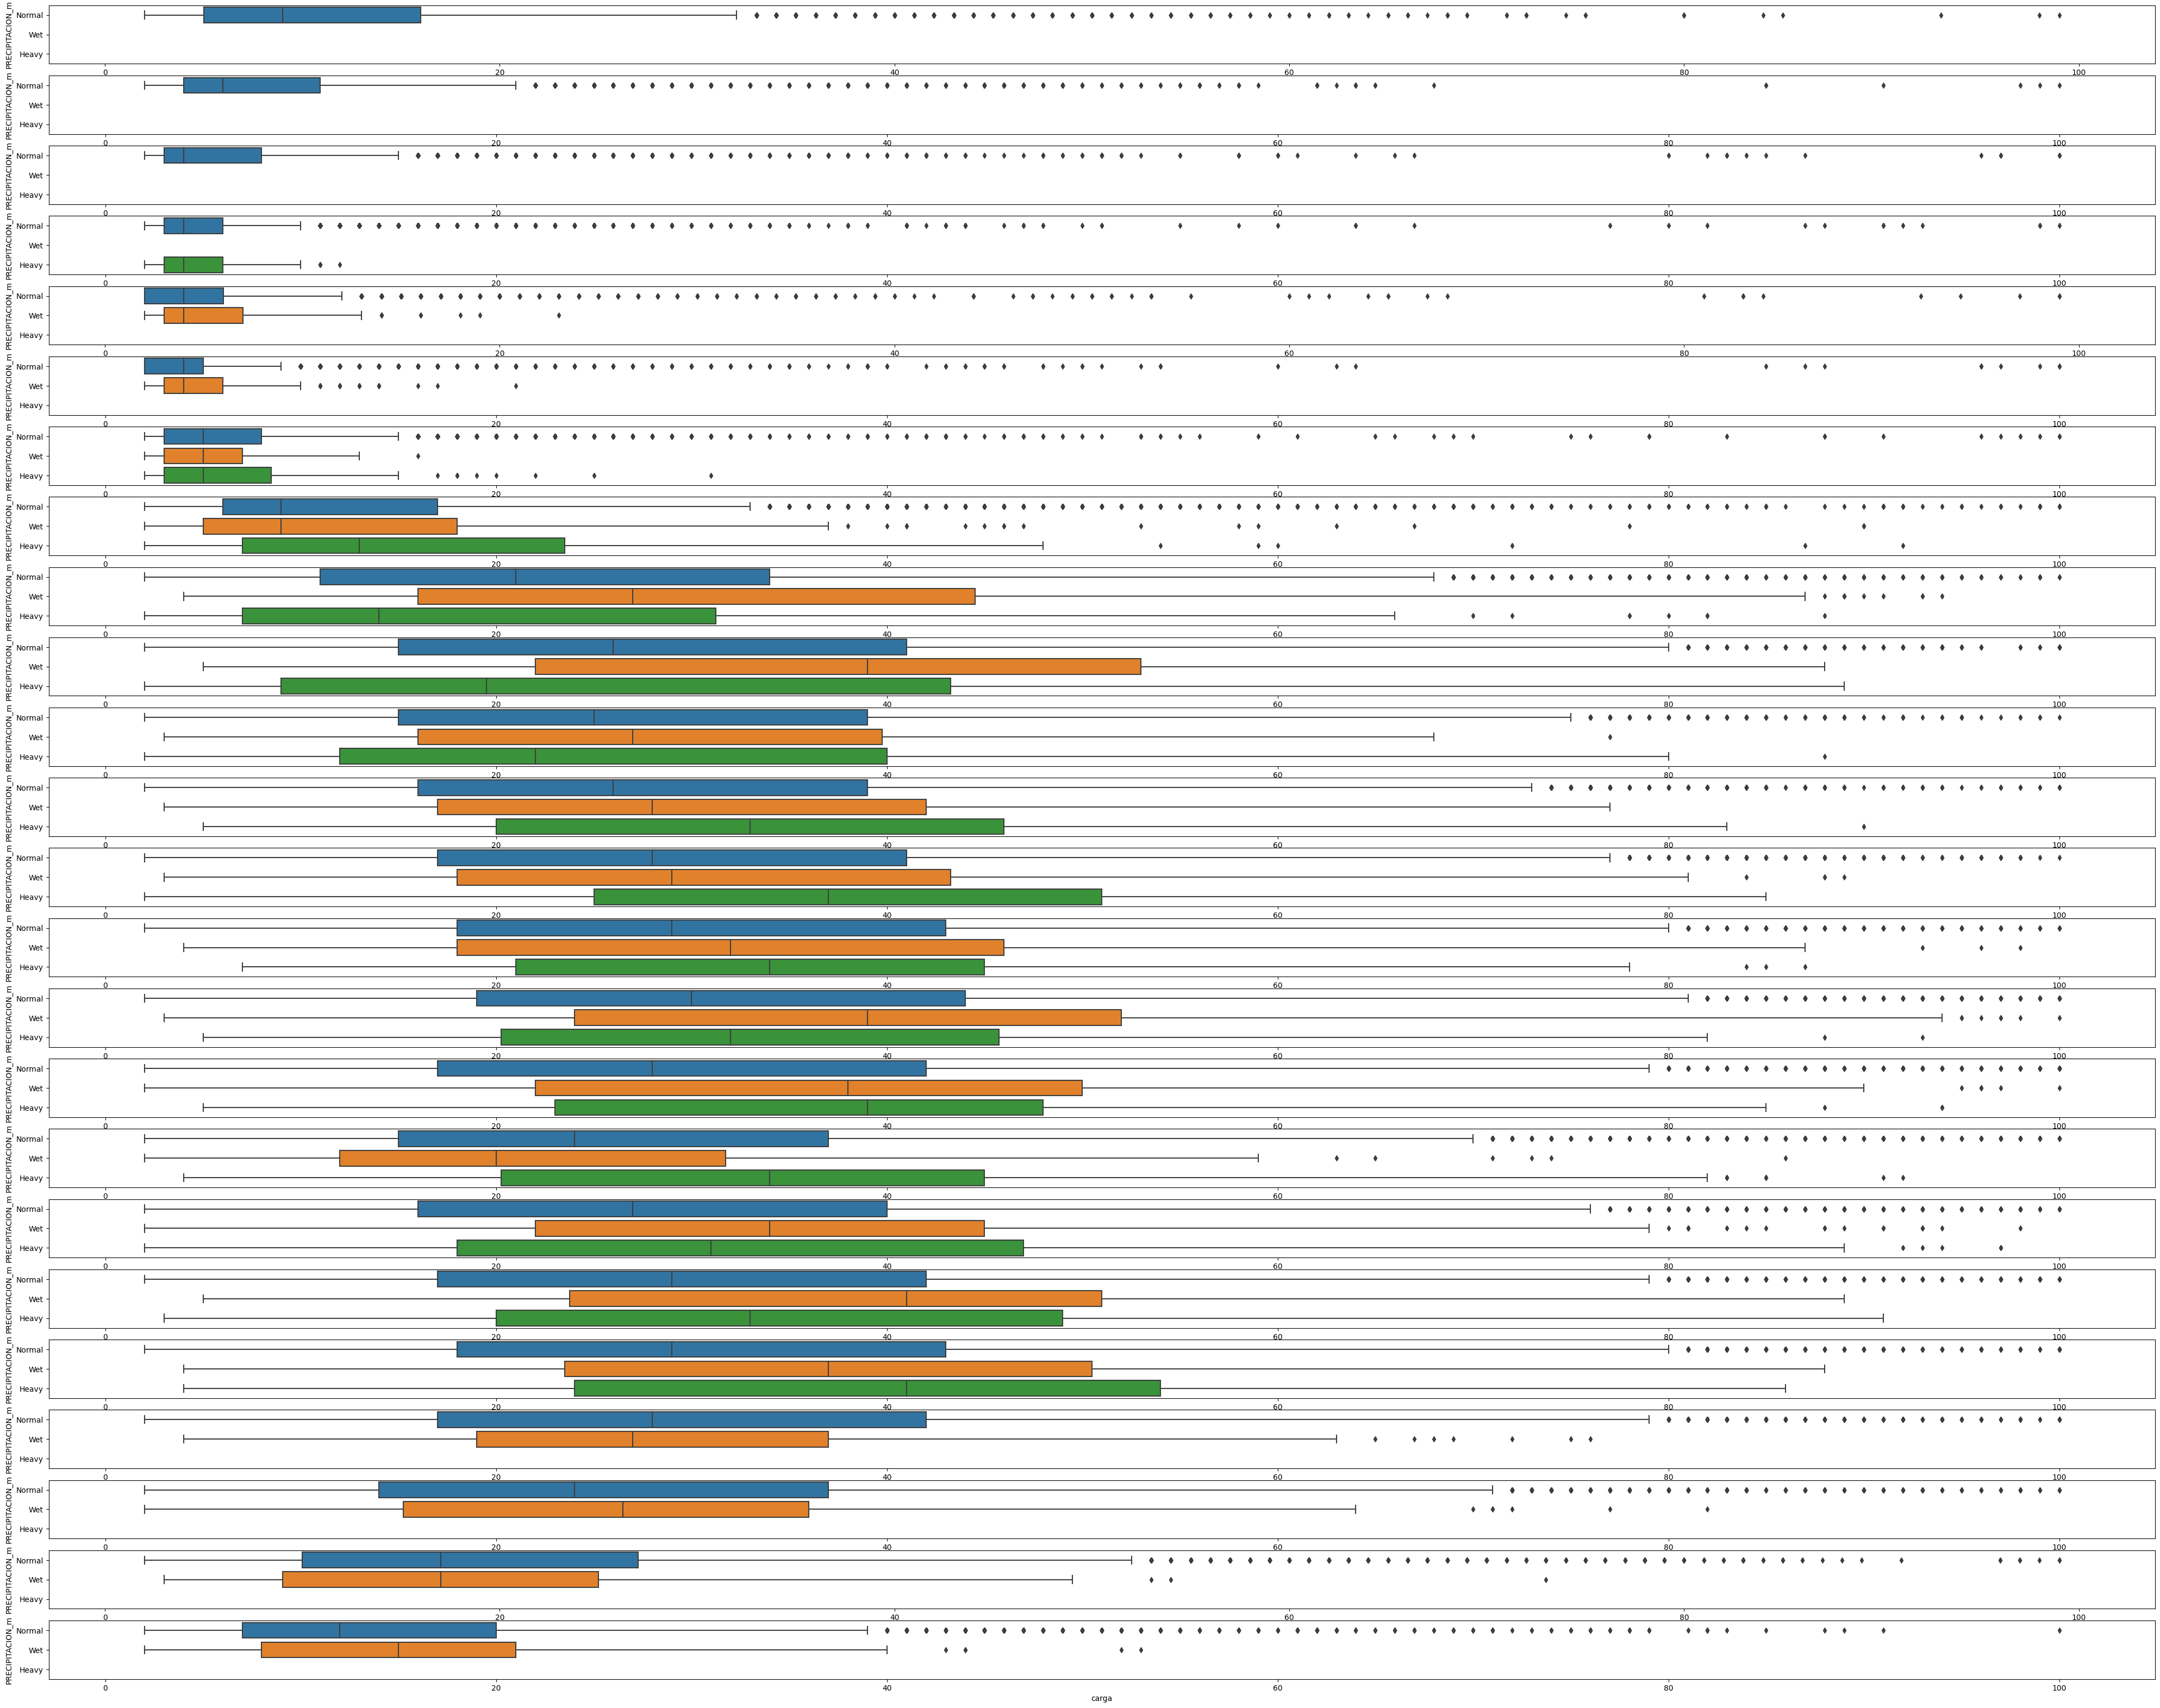

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(24, figsize=(50, 40))
for i in range(24):
    sns.boxplot(x="carga", y="PRECIPITACION_m", data=final[final["HOUR"]==i], ax=ax[i])
#sns.swarmplot(x="carga_v", y="TEMPERATURA", data=final,  ax=ax)
plt.show()

In [99]:
np.unique(final["PRECIPITACION_m"], return_counts=True)

(array(['Heavy', 'Normal', 'Wet'], dtype=object),
 array([  1650, 213083,   2413], dtype=int64))

In [164]:
len(i)

24

HORA  0
                        sum_sq       df         F    PR(>F)
C(PRECIPITACION)  4.651012e+02      1.0  5.448507  0.019594
Residual          1.947643e+06  22816.0       NaN       NaN
ERROR HORA  1
ERROR HORA  2
HORA  3
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)      71.680776      2.0  1.351312  0.258927
Residual          473827.235723  17865.0       NaN       NaN
HORA  4
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)     116.289633      2.0  2.459245  0.085531
Residual          384890.192618  16279.0       NaN       NaN
HORA  5
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)     171.820476      3.0  2.672861  0.045663
Residual          365815.183681  17072.0       NaN       NaN
HORA  6
                         sum_sq       df         F   PR(>F)
C(PRECIPITACION)      76.502359      2.0  1.090316  0.33613
Residual          714633.703796  20370.0       NaN      NaN
HORA  7
               

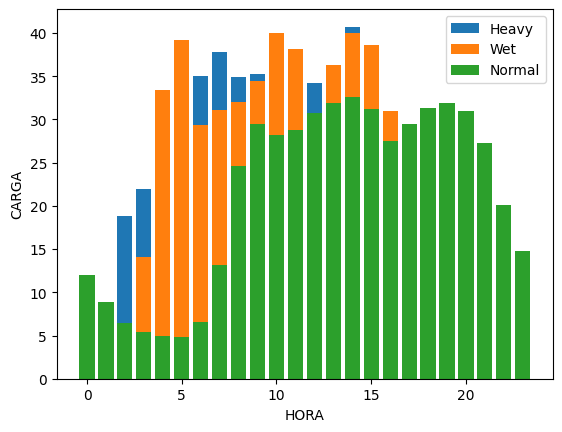

In [181]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


lista = []
j = ["Heavy", "Wet", "Normal"]
for i in j:
    t = final[final["PRECIPITACION_m"]== i]
    lista.append(t[["carga","HOUR",  "PRECIPITACION_m"]].groupby(["HOUR", "PRECIPITACION_m"]).agg({'carga': 'mean'}).dropna().values)

for i in range(24):
    try:
        model = ols('carga ~ C(PRECIPITACION)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('carga ~ C(PRECIPITACION)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
    
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("CARGA")
plt.xlabel("HORA")
plt.show()

In [121]:
final[["carga","HOUR",  "PRECIPITACION_m"]].groupby(["PRECIPITACION_m"]).count()["carga"].values

array([213083,   2413,   1650], dtype=int64)

In [146]:
state_pcts

carga
HOUR HOUR PRECIPITACION_m           
9    9    Normal           30.592622
          Wet              40.742444
          Heavy            28.664934
10   10   Normal           33.159813
          Wet              34.597833
          Heavy            32.242354
11   11   Normal           30.365575
          Wet              32.792100
          Heavy            36.842325
12   12   Normal           30.527473
          Wet              31.836128
          Heavy            37.636399
13   13   Normal           31.510195
          Wet              34.005886
          Heavy            34.483919
14   14   Normal           30.239495
          Wet              37.058320
          Heavy            32.702185
15   15   Normal           28.919655
          Wet              35.417105
          Heavy            35.663240
16   16   Normal           31.997313
          Wet              27.253762
          Heavy            40.748925
17   17   Normal           29.501720
          Wet              36.330094
          Heavy            34.168186

In [145]:
state_pcts = a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

<ipython-input-145-7744e3281638>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  state_pcts = a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


In [91]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('TEMPERATURA ~ C(carga_m)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(carga_m),8.757586e+02,5.0,24.632273,6.825506e-25
Residual,1.544009e+06,217140.0,NaN,NaN


In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('PRECIPITACION ~ C(carga_m)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(carga_m),6.16623,5.0,24.311517,1.492107e-24
Residual,11014.82223,217140.0,NaN,NaN


In [ ]:
import pingouin as pg
pg.pairwise_ttests(
    dv      = 'carga',
    within  = 'PRECIPITACION_m',
    subject = 'TEMPERATURA',
    padjust = 'holm',
    data    = final
)

C:\Users\marco\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [52]:
pip install pingouin

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\anaconda3\python.exe -m pip install --upgrade pip' command.


  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7034 sha256=1c082ebb3aab9bf2e6984a67940f08fc21aeecba3b088be05018ba66e78b344a
  Stored in directory: c:\users\marco\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [48]:
final["TEMPERATURA"] = final["TEMPERATURA"].astype(int)

<ipython-input-48-29c65e1009f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["TEMPERATURA"] = final["TEMPERATURA"].astype(int)


In [ ]:
weather["PRECIPITACION_m"] = pd.cut(weather["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])

In [ ]:
weather["PRECIPITACION"]

In [ ]:
myDictionary

In [ ]:
import matplotlib.pyplot as plt

unique, counts = np.unique(final["PRECIPITACION_m"], return_counts=True)
myDictionary = dict(zip(unique, counts))
plt.bar(myDictionary.keys(), myDictionary.values(), color='g')
plt.show()

In [ ]:
import seaborn as sns
ax = sns.barplot(data=wheather, x='variable', y='value', hue='card_name')
plt.show()

In [ ]:
function measure(lat1, lon1, lat2, lon2){  // generally used geo measurement function
    var R = 6378.137; // Radius of earth in KM
    var dLat = lat2 * Math.PI / 180 - lat1 * Math.PI / 180;
    var dLon = lon2 * Math.PI / 180 - lon1 * Math.PI / 180;
    var a = Math.sin(dLat/2) * Math.sin(dLat/2) +
    Math.cos(lat1 * Math.PI / 180) * Math.cos(lat2 * Math.PI / 180) *
    Math.sin(dLon/2) * Math.sin(dLon/2);
    var c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));
    var d = R * c;
    return d * 1000; // meters
}

r = 6378.137
dLat = lat2 * Math.PI / 180 - lat1 * Math.PI / 180

In [ ]:

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [10]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\anaconda3\python.exe -m pip install --upgrade pip' command.


In [20]:
df4[["LONGITUD", "LATITUD"]].to_numpy()[0]

array([-3.7122567, 40.4238823])

In [30]:
haversine(df4[["LONGITUD", "LATITUD"]].to_numpy()[0], df4[["LONGITUD", "LATITUD"]].to_numpy()[21])

3.5484393496954305

In [35]:
df4[["LONGITUD", "LATITUD"]]

,LONGITUD,LATITUD
0,-3.712257,40.423882
1,-3.682316,40.421553
2,-3.639242,40.440046
3,-3.731836,40.394782
4,-3.747345,40.419358
5,-3.703166,40.419209
6,-3.645310,40.407952
7,-3.707130,40.445544
8,-3.711536,40.478232
9,-3.612139,40.373012


In [ ]:
def test(xs, ys, radius=1):
    return cdist(xs, ys, metric=lambda x, y, radius=radius: distanceMetric(x, y, radius))

In [46]:
df4.to_numpy()

array([[ 2.80790040e+07,  4.00000000e+00, -3.71225670e+00,
         4.04238823e+01],
       [ 2.80790080e+07,  8.00000000e+00, -3.68231580e+00,
         4.04215533e+01],
       [ 2.80790160e+07,  1.60000000e+01, -3.63924220e+00,
         4.04400457e+01],
       [ 2.80790180e+07,  1.80000000e+01, -3.73183560e+00,
         4.03947825e+01],
       [ 2.80790240e+07,  2.40000000e+01, -3.74734450e+00,
         4.04193577e+01],
       [ 2.80790350e+07,  3.50000000e+01, -3.70316620e+00,
         4.04192091e+01],
       [ 2.80790360e+07,  3.60000000e+01, -3.64531040e+00,
         4.04079517e+01],
       [ 2.80790380e+07,  3.80000000e+01, -3.70713030e+00,
         4.04455439e+01],
       [ 2.80790390e+07,  3.90000000e+01, -3.71153640e+00,
         4.04782322e+01],
       [ 2.80790540e+07,  5.40000000e+01, -3.61213940e+00,
         4.03730118e+01],
       [ 2.80790560e+07,  5.60000000e+01, -3.71876790e+00,
         4.03850336e+01],
       [ 2.80790580e+07,  5.80000000e+01, -3.77461010e+00,
      

In [52]:
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist
a1 = df4[[ "LATITUD", "LONGITUD"]].rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
a2 = df3[["\"latitud\"", "\"longitud\""]].rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})
#cdist(a1, a2, method= haversine_vector)
unit = Unit.KILOMETERS 
dm = haversine_vector(a1, a2, unit, comb=True)

closest = dm.argmin(axis=1)
distances = dm.min(axis=1)

In [60]:
unique, counts = np.unique(closest, return_counts=True)
for i, v in zip(unique,counts):
    print(i,": ",v)

0 :  134
1 :  68
2 :  467
3 :  350
4 :  86
5 :  65
6 :  156
7 :  332
8 :  413
9 :  84
10 :  230
11 :  9
12 :  157
13 :  136
14 :  107
15 :  122
16 :  131
17 :  595
18 :  157
19 :  136
20 :  127
21 :  200
22 :  216
24 :  261


In [61]:
np.mean(distances)

1.556835943963195

In [42]:
df4[["LONGITUD", "LATITUD"]]

,LONGITUD,LATITUD
0,-3.712257,40.423882
1,-3.682316,40.421553
2,-3.639242,40.440046
3,-3.731836,40.394782
4,-3.747345,40.419358
5,-3.703166,40.419209
6,-3.645310,40.407952
7,-3.707130,40.445544
8,-3.711536,40.478232
9,-3.612139,40.373012
